# Example 03: Prediction -- Using Output Feedback

In prediction mode, the model receives **both** the input signal u(t) and past
measured outputs y(t-1) to predict the next output. This gives the model a
"peek" at recent measurements, leading to more accurate predictions -- but
requires measured outputs at inference time.

## Prerequisites

This notebook builds on Examples 00-02. In particular, make sure you understand
the simulation concept from Example 02 before reading on, because prediction
mode is defined by how it differs from simulation.

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_silverbox_prediction
from tsfast.prediction.fransys import FranSysLearner
from tsfast.learner.losses import fun_rmse

## Simulation vs. Prediction

This is **the** core conceptual distinction in tsfast. Every modeling choice
flows from this decision:

### Simulation

```
Model input:  [ u(t) ]
Model output: y(t)
```

The model must simulate the system purely from the excitation signal. It never
sees the real output. This is **harder** but more general -- at deployment time,
you only need the input signal.

### Prediction

```
Model input:  [ u(t),  y(t-1) ]
Model output: y(t)
```

The model gets past measured outputs as additional input. This is **easier** and
typically more accurate, because the model can correct itself using recent
measurements. The tradeoff: you need a sensor measuring y at deployment time.

### How tsfast implements prediction

When you load a prediction dataset (e.g., `create_dls_silverbox_prediction`),
the DataLoaders automatically provide `[u(t), y(t-1)]` as the input tensor and
`y(t)` as the target. The input signal u is normalized (z-score), but the
output feedback y stays in **raw physical units**. This mixed normalization is
intentional -- the model learns to work with both scales.

## Load a Prediction Dataset

`create_dls_silverbox_prediction` creates DataLoaders configured for prediction
mode on the Silverbox benchmark. The prediction-mode factory handles the
time-shifting of y(t) to y(t-1) and the concatenation automatically.

In [2]:
dls = create_dls_silverbox_prediction()

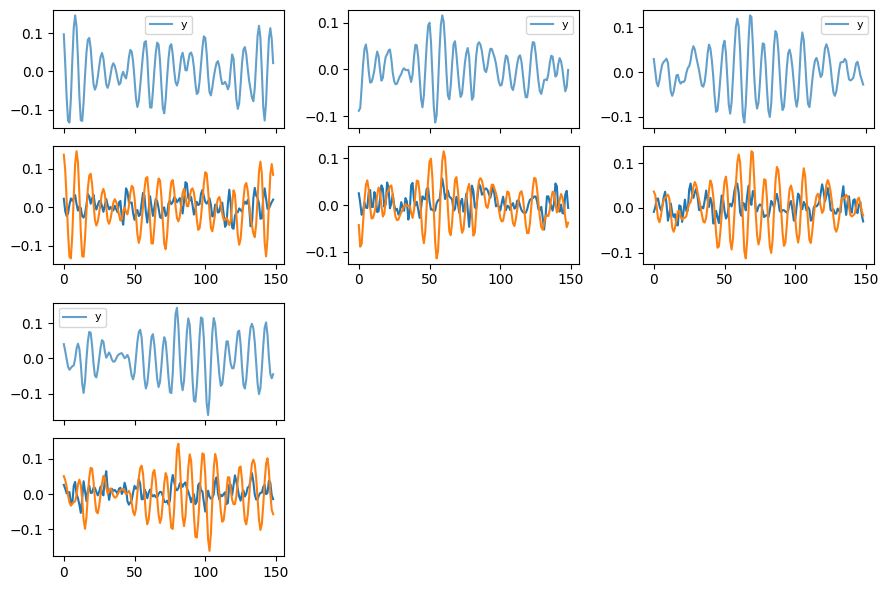

In [3]:
dls.show_batch(max_n=4)

Notice that the input now has **more channels** than in the simulation example.
The extra channels are the measured output values y(t-1) concatenated to u(t).

## The FranSys Architecture

For prediction tasks, tsfast provides the **FranSys** (Framework for Nonlinear
System identification) architecture. It separates the model into two phases:

1. **Diagnosis** (first `init_sz` timesteps): the model processes the
   initialization window -- both input u(t) and measured output y(t-1) -- to
   estimate the system's current internal state from measurement data.

2. **Prognosis** (remaining timesteps): using the estimated state from diagnosis
   as initial hidden state, the model predicts forward using only the input u(t).
   During training, the prognosis module sees the full sequence; during inference,
   it runs autoregressively from the estimated state.

The key insight is that `init_sz` controls how many timesteps are used to
"warm up" the model's hidden state from real data. Predictions are only evaluated
**after** this initialization window, so `init_sz` also acts like `n_skip` --
the first `init_sz` timesteps are excluded from the loss.

## Train a FranSys Model

Key parameters:

- `init_sz=50`: use the first 50 timesteps for state estimation (diagnosis);
  predictions are evaluated on the remainder (prognosis)
- `hidden_size=40`: 40 hidden units in the RNN layers
- `metrics=[fun_rmse]`: track root mean squared error

In [4]:
lrn = FranSysLearner(dls, init_sz=50, hidden_size=40, metrics=[fun_rmse])
lrn.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.003797,0.002539,0.003305,00:04
1,0.002588,0.002949,0.003673,00:03
2,0.001794,0.001458,0.001922,00:03
3,0.001929,0.002268,0.002948,00:03
4,0.001696,0.001799,0.002259,00:03
5,0.002029,0.002379,0.002967,00:02
6,0.001725,0.001423,0.001802,00:02
7,0.001727,0.001719,0.002225,00:02
8,0.000665,0.000501,0.000705,00:03
9,0.000331,0.000297,0.000469,00:03


## Visualize Results

`show_results` overlays predictions against targets on validation windows.
Note the initialization region (first 50 timesteps): the model uses this
window to estimate the system state, so predictions in that region are
zero-padded and excluded from evaluation.

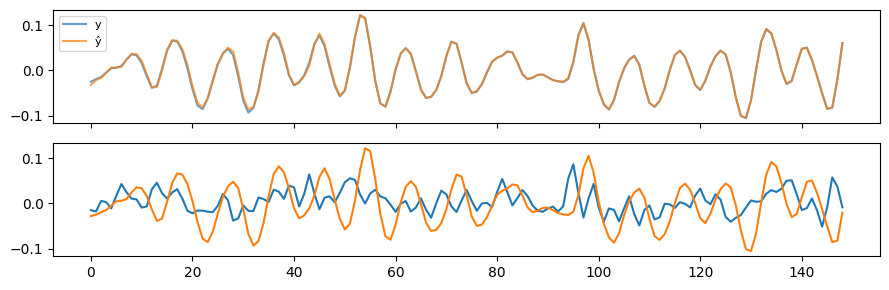

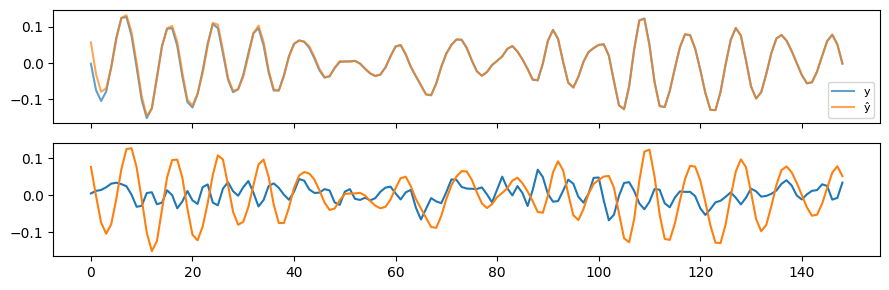

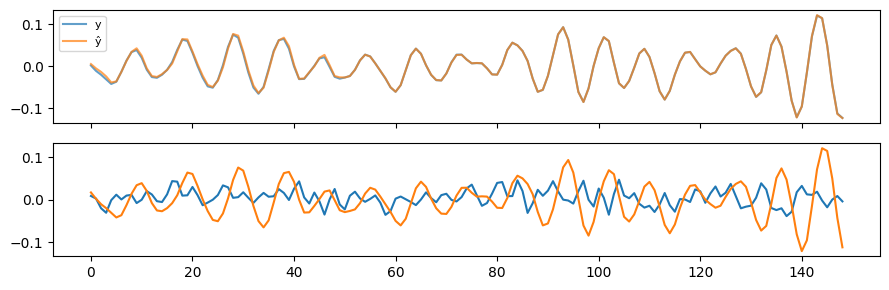

In [5]:
lrn.show_results(max_n=3)

## Key Takeaways

- **Prediction mode feeds past measured outputs back as model input**, giving
  higher accuracy than simulation at the cost of requiring a sensor at deployment.
- **The prediction DataLoaders concatenate `[u_normalized, y_raw]`** -- mixed
  normalization is intentional and the model learns to use both scales.
- **FranSys separates diagnosis from prognosis**: the diagnosis phase estimates
  the system state from an initialization window of real measurements, and the
  prognosis phase predicts forward from that estimated state.
- **`init_sz` controls the initialization window**: more timesteps give better
  state estimates but leave fewer timesteps for evaluated predictions.
- **Prediction requires measured outputs at inference time** -- if you only have
  the input signal, use simulation mode (Example 02) instead.